Common initialization

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Sample blob dataset

In [2]:
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)


In [3]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

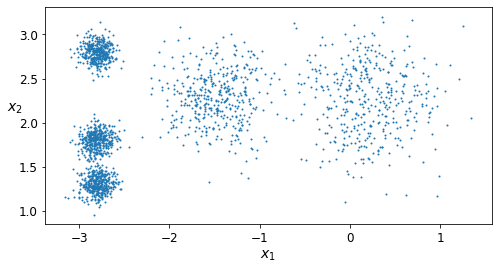

In [4]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

Helper functions

In [24]:
from sklearn.cluster import KMeans

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

### Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

In [6]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

69.7 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [7]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)

187 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Mini-Batch K-Means

Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches (see [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [8]:
from sklearn.cluster import MiniBatchKMeans

In [9]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(n_clusters=5, random_state=42)

In [10]:
minibatch_kmeans.inertia_

211.93186531476786

First let's load MNIST:

In [11]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

If the dataset does not fit in memory, the simplest option is to use the `memmap` class.

Next, let's write it to a `memmap`:

In [13]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [14]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

If your data is so large that you cannot use `memmap`, things get more complicated. Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [15]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now we can train the model by feeding it one batch at a time. We also need to implement multiple initializations and keep the model with the lowest inertia:

In [20]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [17]:
best_kmeans.score(X)

-211.70999744411446

Mini-batch K-Means is much faster than regular K-Means:

In [18]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

40.6 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

18.7 ms ± 486 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's *much* faster! However, its performance is often lower (higher inertia), and it keeps degrading as _k_ increases. Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

In [22]:
from timeit import timeit

times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

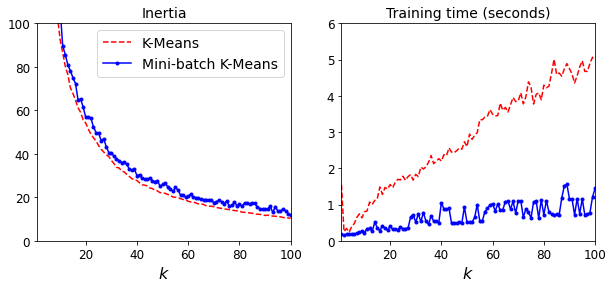

In [23]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()

### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5?

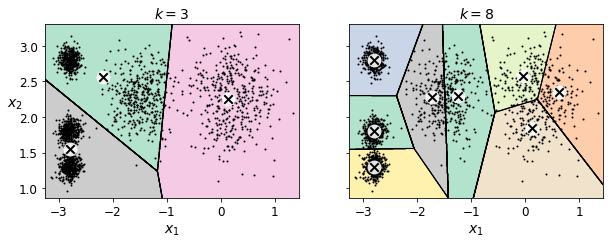

In [25]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [26]:
kmeans_k3.inertia_

653.2167190021556

In [27]:
kmeans_k8.inertia_

119.1198341610289

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [28]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

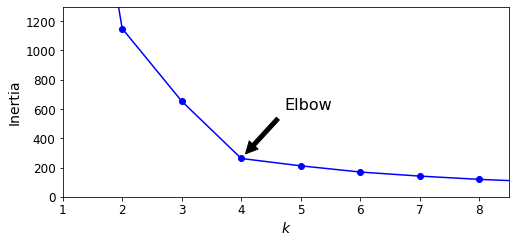

In [29]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

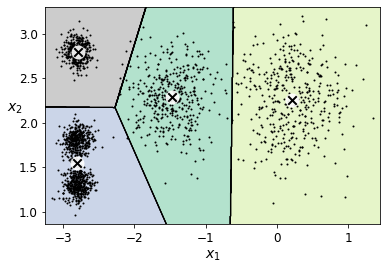

In [30]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [31]:
from sklearn.metrics import silhouette_score

In [32]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)
silhouette_score(X, kmeans.labels_)

0.688531617595759

In [33]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

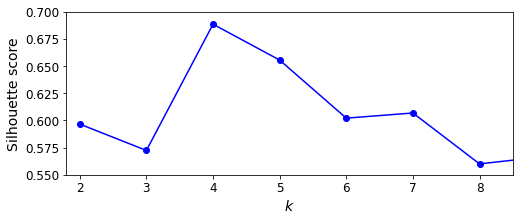

In [34]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

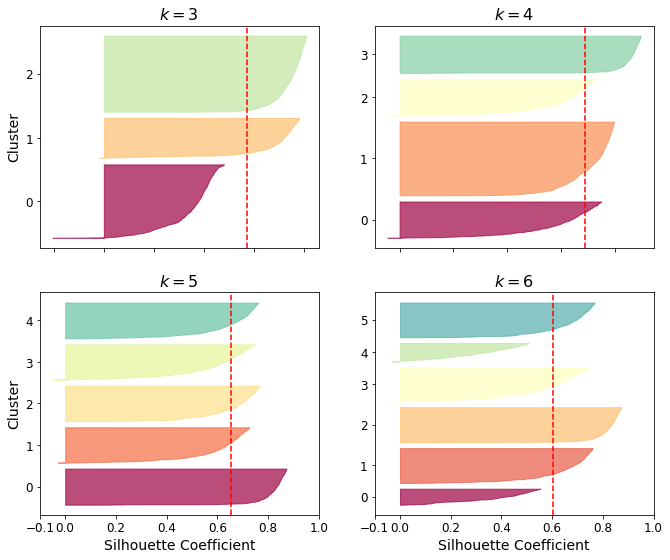

In [35]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

As you can see, $k=5$ looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.